### A quick demonstration of temperature+polarization wiener filtering

In [1]:
import numpy as np
import healpy as hp
from matplotlib.pyplot import *
# from cmblensplus/wrap/
import basic
import curvedsky as cs
# from cmblensplus/utils/
import plottools as pl

In [2]:
# define parameters
Tcmb  = 2.726e6    # CMB temperature
nside = 512        # CMB map resolution
lmax  = 2*nside     # maximum multipole of alm to be generated
npix  = 12*nside**2
l = np.linspace(0,lmax,lmax+1)
lfac = l*(l+1)/2/np.pi
sigma = 100.       # CMB noise in uK-arcmin

In [3]:
# load cl
cl = basic.aps.read_cambcls('../data/lensedcls.dat',2,lmax,4,bb=True)/Tcmb**2

In [4]:
Nl = (sigma*(np.pi/10800.)/Tcmb)**2 * np.ones(lmax+1)

/global/homes/t/toshiyan/.conda/envs/loc/lib/python3.7/site-packages/healpy/fitsfunc.py:367: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


W2 correction and fsky are 0.7480608622233073 0.7480608622233073


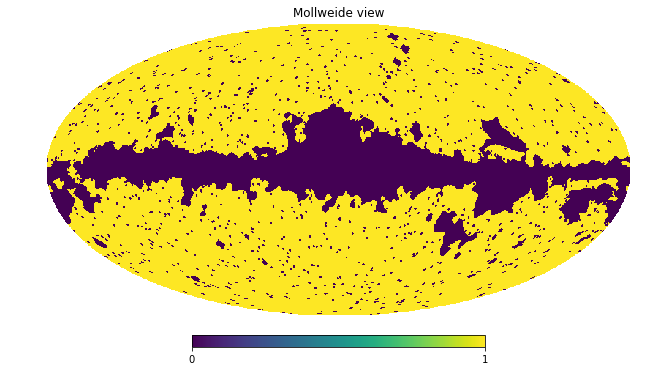

In [5]:
# load survey window
W = hp.fitsfunc.read_map('../data/wmap_temperature_kq85_analysis_mask_r9_9yr_v5.fits',verbose=False)
W = hp.ud_grade(W,nside)
#W = hp.fitsfunc.read_map('/project/projectdirs/sobs/delensing/mask/la_n'+str(nside)+'.fits',verbose=False)
M = W/(W+1e-30) # binary mask
w2 = np.average(W**2)
fsky = np.average(M)
print('W2 correction and fsky are',w2,fsky)
hp.mollview(W)
show()

In [6]:
# Gaussian alms are generated here
alm, nlm = {}, {}
alm['T'], alm['E'], alm['B'] = cs.utils.gaussTEB(lmax,cl[0,:],cl[1,:],cl[2,:],cl[3,:])
nlm['T'] = cs.utils.gauss1alm(lmax,Nl)
nlm['E'] = cs.utils.gauss1alm(lmax,Nl*2)
nlm['B'] = cs.utils.gauss1alm(lmax,Nl*2)

In [7]:
# masked T/Q/U
omap = {}
omap['T'] = cs.utils.hp_alm2map(npix,lmax,lmax,alm['T']+nlm['T'])
omap['Q'], omap['U'] = cs.utils.hp_alm2map_spin(npix,lmax,lmax,2,alm['E']+nlm['E'],alm['B']+nlm['B'])

In [8]:
olm = {}
olm['T'] = cs.utils.hp_map2alm(nside,lmax,lmax,omap['T']*W)
olm['E'], olm['B'] = cs.utils.hp_map2alm_spin(nside,lmax,lmax,2,omap['Q']*W,omap['U']*W)

In [9]:
# inverse noise covariance
invn = W * (sigma*(np.pi/10800.)/Tcmb)**(-2)
invN = np.reshape(np.array((invn,invn*2.,invn*2.)),(3,1,npix))

In [10]:
# Wiener filtering
tqu, nu = 3, 1 # TQU and signal frequency
bl = np.ones((1,lmax+1)) # beam function
TQU = np.reshape(np.array((omap['T']*M,omap['Q']*M,omap['U']*M)),(3,1,npix)) # restrict T, Q, U to observed area
wlm = {}
wlm['T'], wlm['E'], wlm['B'] = cs.cninv.cnfilter_freq(tqu,nu,npix,lmax,cl[0:3,:],bl,invN,TQU,chn=1,itns=[1000],eps=[1e-5],filter='W',ro=10,stat='status.txt')

In [11]:
var=!cat 'status.txt'
print(var)

[' precompute diagonal preconditioner', ' initial residual   554258.320682805      |b|^2   1688983.43883400     ', '          10  1.629435779442925E-003  2.564827849526166E-005', '          20  2.566004346538398E-004  4.280533364290054E-006', '          30  9.566243119645503E-005  1.467709606765693E-006', '          40  3.030783662874780E-005  3.064210599789879E-007', '          50  3.145478663642873E-005  1.653354184900769E-007', '          60  2.570461962354620E-005  1.187176282146128E-007', '          70  2.216826344483763E-005  8.453430972287912E-008', '          80  1.191741160657155E-005  4.316112716202324E-008', '          85  9.368360363058134E-006', ' real time:   161.237129000000     ']


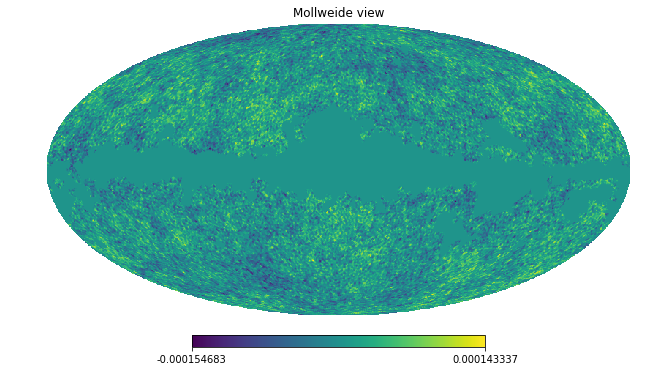

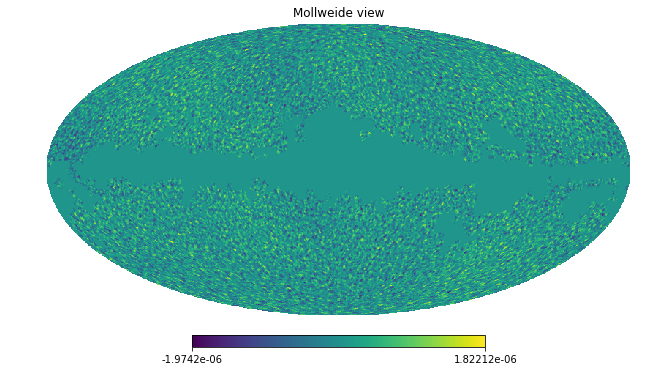

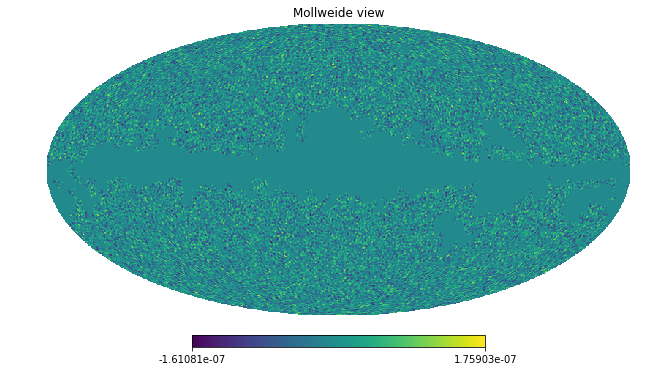

In [12]:
lmax0 = 128*2
npix0 = 12*128**2
M0 = hp.ud_grade(M,128)
for s in ['T','E','B']:
    Map = M0*cs.utils.hp_alm2map(npix0,lmax0,lmax0,alm[s][:lmax0+1,:lmax0+1])
    hp.mollview(Map)

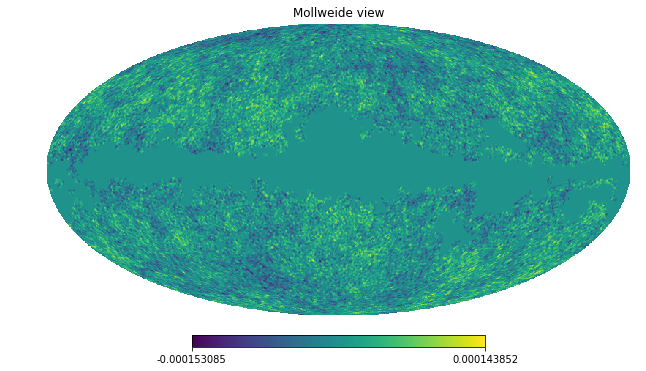

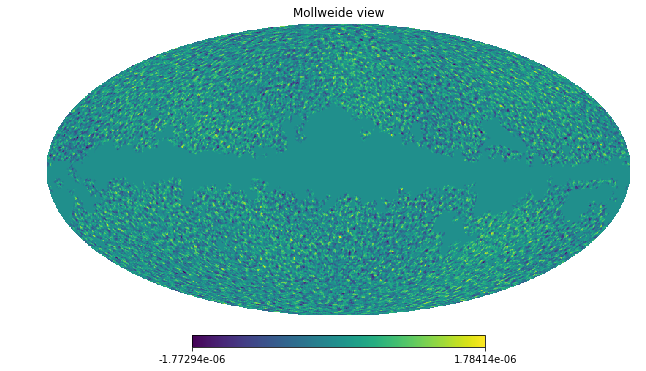

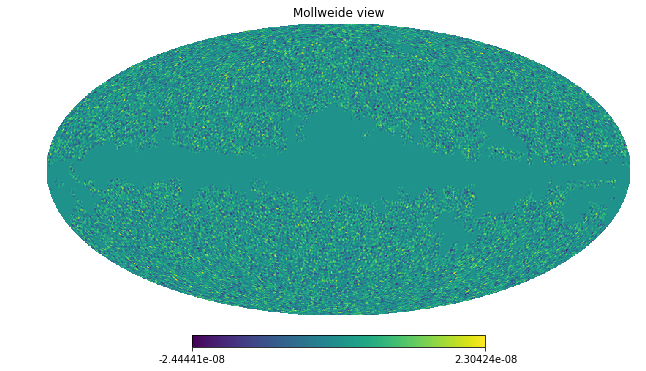

In [13]:
for s in ['T','E','B']:
    wmap = M0*cs.utils.hp_alm2map(npix0,lmax0,lmax0,wlm[s][:lmax0+1,:lmax0+1])
    hp.mollview(wmap)

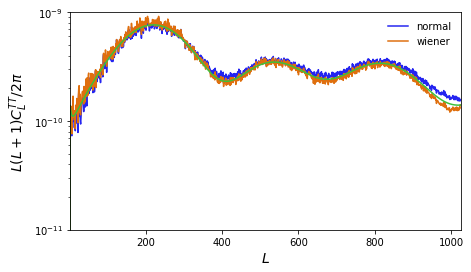

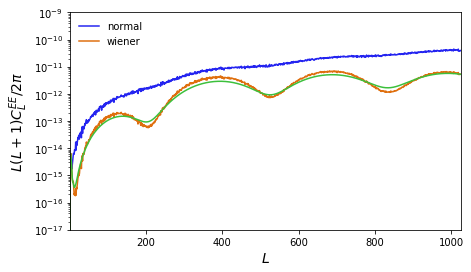

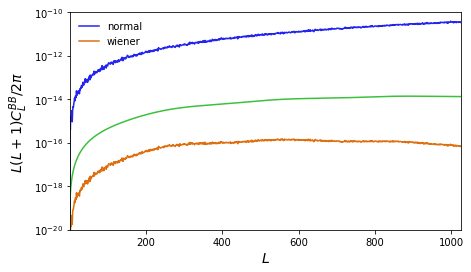

<Figure size 504x288 with 0 Axes>

In [15]:
for i, (m, y0, y1) in enumerate([('T',1e-11,1e-9),('E',1e-17,1e-9),('B',1e-20,1e-10)]):
    pl.plot_1dstyle(fsize=[7,4],xmin=2,xmax=lmax,ymin=y0,ymax=y1,ylog=True,ylab=r'$L(L+1)C_L^{'+m+m+'}/2\pi$')
    cl0 = cs.utils.alm2cl(lmax,olm[m])/w2
    cl1 = cs.utils.alm2cl(lmax,wlm[m])/fsky
    plot(l,lfac*cl0,label='normal')
    plot(l,lfac*cl1,label='wiener')
    plot(l,lfac*cl[i,:])
    legend()
    show()
    clf()